In [1]:
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from diffusers import DDPMScheduler, UNet2DModel, UNet2DConditionModel
from torchvision.transforms import v2
from matplotlib import pyplot as plt
from tqdm.auto import tqdm
import numpy as np

import data.dataset as ds
import data.CI as CI

device = "mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

model_name = 'UNet2DCondition'

/home/lai075/miniconda3/envs/hf/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda


In [2]:
def gauss_noise_tensor(img):
    assert isinstance(img, torch.Tensor)
    dtype = img.dtype
    if not img.is_floating_point():
        img = img.to(torch.float32)
    
    sigma = 0.01
    
    out = img + sigma * torch.randn_like(img)
    
    if out.dtype != dtype:
        out = out.to(dtype)
        
    return out

train_transforms = v2.Compose([
    v2.ToTensor(),
    # gauss_noise_tensor,
    v2.RandomHorizontalFlip(),
    v2.RandomVerticalFlip(),
    v2.RandomRotation(90, interpolation=torchvision.transforms.InterpolationMode.BILINEAR),
    v2.GaussianBlur(3, sigma=(0.1, 0.5)),
    v2.CenterCrop(64),
])

val_transforms = v2.Compose([
    v2.ToTensor(),
    v2.CenterCrop(64),
])

Img Shape: torch.Size([1, 64, 64])
CI Shape: torch.Size([120])
Class Shape: torch.Size([5])

16348
Input shape: torch.Size([8, 1, 64, 64])
Labels: tensor([4, 0, 4, 4, 4, 4, 4, 4])


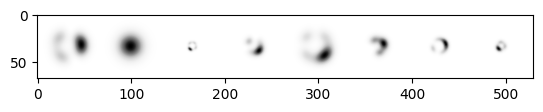

In [3]:
# Load the dataset
batch_size = 8


data_dir = 'data/datasets/v2/'
mnames = ['gauss', 'disk', 'ellipse', 'ring', 'mring']

filenames = np.array([data_dir + 'imgs_' + m + '.npy' for m in mnames])
dataset = ds.ImgDataset(filenames, transform=train_transforms)

print('Img Shape:', dataset[0][0].shape)
print('CI Shape:', dataset[0][1].shape)
print('Class Shape:', dataset[0][2].shape)

print()
print(len(dataset))

# Feed it into a dataloader (batch size 8 here just for demo)
train_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# View some examples
x, ci, y = next(iter(train_dataloader))
y = torch.argmax(y, dim=1)
print("Input shape:", x.shape)
print("Labels:", y)
plt.imshow(torchvision.utils.make_grid(x)[0], cmap="Greys")

In [4]:
class UNet2DCondition(nn.Module):
    def __init__(self, ci_dim=120, time_cond_proj_dim=512):
        super().__init__()

        # Self.model is an unconditional UNet with extra input channels to accept the conditioning information (the class embedding)
        self.model = UNet2DConditionModel(
            sample_size=64,  # the target image resolution
            in_channels=1, # Additional input channels for class cond.
            out_channels=1,  # the number of output channels
            layers_per_block=2,  # how many ResNet layers to use per UNet block
            block_out_channels=(32, 64, 64),
            down_block_types=(
                "DownBlock2D",  # a regular ResNet downsampling block
                "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
                "AttnDownBlock2D",
            ),
            up_block_types=(
                "AttnUpBlock2D",
                "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
                "UpBlock2D",  # a regular ResNet upsampling block
            ),
            # cross_attention_dim = 1,
            encoder_hid_dim=ci_dim,
            time_cond_proj_dim=time_cond_proj_dim,
        )

        

    # Our forward method now takes the class labels as an additional argument
    def forward(self, x, t, ci, guidance_scale=None):
        # Shape of x:
        bs, ch, w, h = x.shape

        if guidance_scale is not None:
            guidance_scale_tensor = torch.tensor(guidance_scale - 1).repeat(bs)
            timestep_cond = self.get_guidance_scale_embedding(guidance_scale_tensor, embedding_dim=self.model.config.time_cond_proj_dim).to(device=device, dtype=x.dtype)
        else:
            timestep_cond = None

        return self.model(x,t,ci, timestep_cond=timestep_cond).sample

    def get_guidance_scale_embedding(self, w: torch.Tensor, embedding_dim: int = 512, dtype: torch.dtype = torch.float32) -> torch.Tensor:
        """
        See https://github.com/google-research/vdm/blob/dc27b98a554f65cdc654b800da5aa1846545d41b/model_vdm.py#L298

        Args:
            w (`torch.Tensor`):
                Generate embedding vectors with a specified guidance scale to subsequently enrich timestep embeddings.
            embedding_dim (`int`, *optional*, defaults to 512):
                Dimension of the embeddings to generate.
            dtype (`torch.dtype`, *optional*, defaults to `torch.float32`):
                Data type of the generated embeddings.

        Returns:
            `torch.Tensor`: Embedding vectors with shape `(len(w), embedding_dim)`.
        """
        assert len(w.shape) == 1
        w = w * 1000.0

        half_dim = embedding_dim // 2
        emb = torch.log(torch.tensor(10000.0)) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, dtype=dtype) * -emb)
        emb = w.to(dtype)[:, None] * emb[None, :]
        emb = torch.cat([torch.sin(emb), torch.cos(emb)], dim=1)
        if embedding_dim % 2 == 1:  # zero pad
            emb = torch.nn.functional.pad(emb, (0, 1))
        assert emb.shape == (w.shape[0], embedding_dim)
        return emb

In [5]:
# Create a scheduler
noise_scheduler = DDPMScheduler(num_train_timesteps=1000, beta_schedule="squaredcos_cap_v2")
# Our network
net = UNet2DCondition().to(device)

# Keeping a record of the losses for later viewing
losses = []

In [6]:
# Training loop :

# Redefining the dataloader to set the batch size higher than the demo of 8
train_dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

# How many runs through the data should we do?
n_epochs = 150

# Our loss function
loss_fn = nn.MSELoss()

# The optimizer
opt = torch.optim.Adam(net.parameters(), lr=1e-3)


# The training loop
for epoch in range(n_epochs):
    for x, ci, y in tqdm(train_dataloader):
        y = torch.argmax(y, dim=1)
        # Get some data and prepare the corrupted version
        x = x.to(device) * 2 - 1  # Data on the GPU (mapped to (-1, 1))
        y = y.to(device)
        ci = ci.reshape(-1, 1, ci.shape[-1]).to(device)

        noise = torch.randn_like(x)
        timesteps = torch.randint(0, 999, (x.shape[0],)).long().to(device)
        noisy_x = noise_scheduler.add_noise(x, noise, timesteps)

        # Get the model prediction
        pred = net(noisy_x, timesteps, ci)  


        # Calculate the loss
        loss = loss_fn(pred, noise)  # How close is the output to the noise

        # Backprop and update the params:
        opt.zero_grad()
        loss.backward()
        opt.step()

        # Store the loss for later
        losses.append(loss.item())

    # Print out the average of the last 100 loss values to get an idea of progress:
    avg_loss = sum(losses[-100:]) / 100
    print(f"Finished epoch {epoch+1}. Average of the last 100 loss values: {avg_loss:05f}")


  0%|          | 0/128 [00:00<?, ?it/s]

100%|██████████| 128/128 [02:39<00:00,  1.25s/it]


Finished epoch 1. Average of the last 100 loss values: 0.018011


100%|██████████| 128/128 [02:37<00:00,  1.23s/it]


Finished epoch 2. Average of the last 100 loss values: 0.008074


100%|██████████| 128/128 [02:38<00:00,  1.24s/it]


Finished epoch 3. Average of the last 100 loss values: 0.006066


100%|██████████| 128/128 [02:37<00:00,  1.23s/it]


Finished epoch 4. Average of the last 100 loss values: 0.005411


100%|██████████| 128/128 [02:38<00:00,  1.24s/it]


Finished epoch 5. Average of the last 100 loss values: 0.004629


100%|██████████| 128/128 [02:37<00:00,  1.23s/it]


Finished epoch 6. Average of the last 100 loss values: 0.004323


100%|██████████| 128/128 [02:38<00:00,  1.23s/it]


Finished epoch 7. Average of the last 100 loss values: 0.004161


100%|██████████| 128/128 [02:38<00:00,  1.24s/it]


Finished epoch 8. Average of the last 100 loss values: 0.003824


100%|██████████| 128/128 [02:37<00:00,  1.23s/it]


Finished epoch 9. Average of the last 100 loss values: 0.003717


100%|██████████| 128/128 [02:38<00:00,  1.24s/it]


Finished epoch 10. Average of the last 100 loss values: 0.003656


100%|██████████| 128/128 [02:38<00:00,  1.24s/it]


Finished epoch 11. Average of the last 100 loss values: 0.003441


100%|██████████| 128/128 [02:38<00:00,  1.24s/it]


Finished epoch 12. Average of the last 100 loss values: 0.003250


100%|██████████| 128/128 [02:38<00:00,  1.24s/it]


Finished epoch 13. Average of the last 100 loss values: 0.003135


100%|██████████| 128/128 [02:37<00:00,  1.23s/it]


Finished epoch 14. Average of the last 100 loss values: 0.003145


100%|██████████| 128/128 [02:37<00:00,  1.23s/it]


Finished epoch 15. Average of the last 100 loss values: 0.003148


100%|██████████| 128/128 [02:37<00:00,  1.23s/it]


Finished epoch 16. Average of the last 100 loss values: 0.003026


100%|██████████| 128/128 [02:37<00:00,  1.23s/it]


Finished epoch 17. Average of the last 100 loss values: 0.002908


100%|██████████| 128/128 [02:38<00:00,  1.23s/it]


Finished epoch 18. Average of the last 100 loss values: 0.002892


100%|██████████| 128/128 [02:37<00:00,  1.23s/it]


Finished epoch 19. Average of the last 100 loss values: 0.002804


100%|██████████| 128/128 [02:38<00:00,  1.24s/it]


Finished epoch 20. Average of the last 100 loss values: 0.002802


100%|██████████| 128/128 [02:37<00:00,  1.23s/it]


Finished epoch 21. Average of the last 100 loss values: 0.002604


100%|██████████| 128/128 [02:38<00:00,  1.23s/it]


Finished epoch 22. Average of the last 100 loss values: 0.002716


100%|██████████| 128/128 [02:41<00:00,  1.26s/it]


Finished epoch 23. Average of the last 100 loss values: 0.002623


100%|██████████| 128/128 [02:53<00:00,  1.36s/it]


Finished epoch 24. Average of the last 100 loss values: 0.002582


100%|██████████| 128/128 [02:48<00:00,  1.32s/it]


Finished epoch 25. Average of the last 100 loss values: 0.002526


100%|██████████| 128/128 [02:55<00:00,  1.37s/it]


Finished epoch 26. Average of the last 100 loss values: 0.002851


100%|██████████| 128/128 [02:47<00:00,  1.31s/it]


Finished epoch 27. Average of the last 100 loss values: 0.002527


100%|██████████| 128/128 [02:48<00:00,  1.31s/it]


Finished epoch 28. Average of the last 100 loss values: 0.002521


100%|██████████| 128/128 [02:46<00:00,  1.30s/it]


Finished epoch 29. Average of the last 100 loss values: 0.002519


100%|██████████| 128/128 [02:48<00:00,  1.32s/it]


Finished epoch 30. Average of the last 100 loss values: 0.002407


100%|██████████| 128/128 [02:49<00:00,  1.32s/it]


Finished epoch 31. Average of the last 100 loss values: 0.002362


100%|██████████| 128/128 [02:47<00:00,  1.31s/it]


Finished epoch 32. Average of the last 100 loss values: 0.002392


100%|██████████| 128/128 [02:48<00:00,  1.32s/it]


Finished epoch 33. Average of the last 100 loss values: 0.002381


100%|██████████| 128/128 [02:47<00:00,  1.31s/it]


Finished epoch 34. Average of the last 100 loss values: 0.002401


100%|██████████| 128/128 [03:08<00:00,  1.47s/it]


Finished epoch 35. Average of the last 100 loss values: 0.002388


100%|██████████| 128/128 [03:43<00:00,  1.75s/it]


Finished epoch 36. Average of the last 100 loss values: 0.002308


100%|██████████| 128/128 [02:48<00:00,  1.32s/it]


Finished epoch 37. Average of the last 100 loss values: 0.002218


100%|██████████| 128/128 [02:48<00:00,  1.31s/it]


Finished epoch 38. Average of the last 100 loss values: 0.002246


100%|██████████| 128/128 [02:48<00:00,  1.32s/it]


Finished epoch 39. Average of the last 100 loss values: 0.002228


100%|██████████| 128/128 [02:49<00:00,  1.32s/it]


Finished epoch 40. Average of the last 100 loss values: 0.002163


100%|██████████| 128/128 [02:46<00:00,  1.30s/it]


Finished epoch 41. Average of the last 100 loss values: 0.002163


100%|██████████| 128/128 [02:38<00:00,  1.24s/it]


Finished epoch 42. Average of the last 100 loss values: 0.002184


100%|██████████| 128/128 [02:44<00:00,  1.29s/it]


Finished epoch 43. Average of the last 100 loss values: 0.002111


100%|██████████| 128/128 [02:51<00:00,  1.34s/it]


Finished epoch 44. Average of the last 100 loss values: 0.002118


100%|██████████| 128/128 [02:48<00:00,  1.31s/it]


Finished epoch 45. Average of the last 100 loss values: 0.002139


100%|██████████| 128/128 [02:47<00:00,  1.31s/it]


Finished epoch 46. Average of the last 100 loss values: 0.002062


100%|██████████| 128/128 [02:51<00:00,  1.34s/it]


Finished epoch 47. Average of the last 100 loss values: 0.002056


100%|██████████| 128/128 [02:47<00:00,  1.31s/it]


Finished epoch 48. Average of the last 100 loss values: 0.002162


100%|██████████| 128/128 [02:47<00:00,  1.31s/it]


Finished epoch 49. Average of the last 100 loss values: 0.002073


100%|██████████| 128/128 [02:46<00:00,  1.30s/it]


Finished epoch 50. Average of the last 100 loss values: 0.001994


100%|██████████| 128/128 [02:49<00:00,  1.32s/it]


Finished epoch 51. Average of the last 100 loss values: 0.001980


100%|██████████| 128/128 [02:48<00:00,  1.32s/it]


Finished epoch 52. Average of the last 100 loss values: 0.002210


100%|██████████| 128/128 [02:47<00:00,  1.31s/it]


Finished epoch 53. Average of the last 100 loss values: 0.002193


100%|██████████| 128/128 [02:49<00:00,  1.32s/it]


Finished epoch 54. Average of the last 100 loss values: 0.002017


100%|██████████| 128/128 [02:49<00:00,  1.33s/it]


Finished epoch 55. Average of the last 100 loss values: 0.002059


100%|██████████| 128/128 [02:48<00:00,  1.32s/it]


Finished epoch 56. Average of the last 100 loss values: 0.001960


100%|██████████| 128/128 [02:53<00:00,  1.35s/it]


Finished epoch 57. Average of the last 100 loss values: 0.001968


100%|██████████| 128/128 [02:47<00:00,  1.31s/it]


Finished epoch 58. Average of the last 100 loss values: 0.001983


100%|██████████| 128/128 [02:46<00:00,  1.30s/it]


Finished epoch 59. Average of the last 100 loss values: 0.001892


100%|██████████| 128/128 [02:47<00:00,  1.31s/it]


Finished epoch 60. Average of the last 100 loss values: 0.001929


100%|██████████| 128/128 [02:49<00:00,  1.32s/it]


Finished epoch 61. Average of the last 100 loss values: 0.002012


100%|██████████| 128/128 [02:48<00:00,  1.31s/it]


Finished epoch 62. Average of the last 100 loss values: 0.002004


100%|██████████| 128/128 [02:48<00:00,  1.32s/it]


Finished epoch 63. Average of the last 100 loss values: 0.001871


100%|██████████| 128/128 [02:47<00:00,  1.31s/it]


Finished epoch 64. Average of the last 100 loss values: 0.001930


100%|██████████| 128/128 [02:49<00:00,  1.32s/it]


Finished epoch 65. Average of the last 100 loss values: 0.001963


100%|██████████| 128/128 [02:47<00:00,  1.31s/it]


Finished epoch 66. Average of the last 100 loss values: 0.001978


100%|██████████| 128/128 [02:47<00:00,  1.31s/it]


Finished epoch 67. Average of the last 100 loss values: 0.001900


100%|██████████| 128/128 [02:52<00:00,  1.35s/it]


Finished epoch 68. Average of the last 100 loss values: 0.001860


100%|██████████| 128/128 [02:49<00:00,  1.32s/it]


Finished epoch 69. Average of the last 100 loss values: 0.001884


100%|██████████| 128/128 [02:49<00:00,  1.32s/it]


Finished epoch 70. Average of the last 100 loss values: 0.001782


100%|██████████| 128/128 [02:48<00:00,  1.32s/it]


Finished epoch 71. Average of the last 100 loss values: 0.001814


100%|██████████| 128/128 [02:48<00:00,  1.32s/it]


Finished epoch 72. Average of the last 100 loss values: 0.001791


100%|██████████| 128/128 [03:29<00:00,  1.63s/it]


Finished epoch 73. Average of the last 100 loss values: 0.001799


100%|██████████| 128/128 [03:55<00:00,  1.84s/it]


Finished epoch 74. Average of the last 100 loss values: 0.001865


100%|██████████| 128/128 [02:55<00:00,  1.37s/it]


Finished epoch 75. Average of the last 100 loss values: 0.001784


100%|██████████| 128/128 [02:48<00:00,  1.32s/it]


Finished epoch 76. Average of the last 100 loss values: 0.001746


100%|██████████| 128/128 [03:42<00:00,  1.74s/it]


Finished epoch 77. Average of the last 100 loss values: 0.001795


100%|██████████| 128/128 [03:04<00:00,  1.44s/it]


Finished epoch 78. Average of the last 100 loss values: 0.001705


100%|██████████| 128/128 [02:48<00:00,  1.32s/it]


Finished epoch 79. Average of the last 100 loss values: 0.001692


100%|██████████| 128/128 [02:42<00:00,  1.27s/it]


Finished epoch 80. Average of the last 100 loss values: 0.001702


100%|██████████| 128/128 [02:38<00:00,  1.23s/it]


Finished epoch 81. Average of the last 100 loss values: 0.001760


100%|██████████| 128/128 [02:41<00:00,  1.26s/it]


Finished epoch 82. Average of the last 100 loss values: 0.001713


100%|██████████| 128/128 [02:49<00:00,  1.32s/it]


Finished epoch 83. Average of the last 100 loss values: 0.001652


100%|██████████| 128/128 [02:40<00:00,  1.25s/it]


Finished epoch 84. Average of the last 100 loss values: 0.001687


100%|██████████| 128/128 [02:47<00:00,  1.31s/it]


Finished epoch 85. Average of the last 100 loss values: 0.001692


100%|██████████| 128/128 [02:44<00:00,  1.28s/it]


Finished epoch 86. Average of the last 100 loss values: 0.001676


100%|██████████| 128/128 [02:40<00:00,  1.26s/it]


Finished epoch 87. Average of the last 100 loss values: 0.001601


100%|██████████| 128/128 [02:51<00:00,  1.34s/it]


Finished epoch 88. Average of the last 100 loss values: 0.001644


100%|██████████| 128/128 [02:42<00:00,  1.27s/it]


Finished epoch 89. Average of the last 100 loss values: 0.001637


100%|██████████| 128/128 [02:48<00:00,  1.32s/it]


Finished epoch 90. Average of the last 100 loss values: 0.001619


100%|██████████| 128/128 [02:54<00:00,  1.36s/it]


Finished epoch 91. Average of the last 100 loss values: 0.001575


100%|██████████| 128/128 [02:53<00:00,  1.36s/it]


Finished epoch 92. Average of the last 100 loss values: 0.001631


100%|██████████| 128/128 [02:54<00:00,  1.36s/it]


Finished epoch 93. Average of the last 100 loss values: 0.001592


100%|██████████| 128/128 [02:51<00:00,  1.34s/it]


Finished epoch 94. Average of the last 100 loss values: 0.001583


100%|██████████| 128/128 [02:53<00:00,  1.35s/it]


Finished epoch 95. Average of the last 100 loss values: 0.001620


100%|██████████| 128/128 [02:55<00:00,  1.37s/it]


Finished epoch 96. Average of the last 100 loss values: 0.001568


100%|██████████| 128/128 [02:53<00:00,  1.36s/it]


Finished epoch 97. Average of the last 100 loss values: 0.001656


100%|██████████| 128/128 [02:56<00:00,  1.38s/it]


Finished epoch 98. Average of the last 100 loss values: 0.001616


100%|██████████| 128/128 [02:53<00:00,  1.36s/it]


Finished epoch 99. Average of the last 100 loss values: 0.001586


100%|██████████| 128/128 [02:53<00:00,  1.36s/it]


Finished epoch 100. Average of the last 100 loss values: 0.001496


100%|██████████| 128/128 [02:50<00:00,  1.33s/it]


Finished epoch 101. Average of the last 100 loss values: 0.001520


100%|██████████| 128/128 [02:55<00:00,  1.37s/it]


Finished epoch 102. Average of the last 100 loss values: 0.001558


100%|██████████| 128/128 [02:57<00:00,  1.38s/it]


Finished epoch 103. Average of the last 100 loss values: 0.001482


100%|██████████| 128/128 [02:49<00:00,  1.32s/it]


Finished epoch 104. Average of the last 100 loss values: 0.001562


100%|██████████| 128/128 [02:53<00:00,  1.35s/it]


Finished epoch 105. Average of the last 100 loss values: 0.001575


100%|██████████| 128/128 [02:51<00:00,  1.34s/it]


Finished epoch 106. Average of the last 100 loss values: 0.001536


100%|██████████| 128/128 [02:52<00:00,  1.35s/it]


Finished epoch 107. Average of the last 100 loss values: 0.001574


100%|██████████| 128/128 [02:51<00:00,  1.34s/it]


Finished epoch 108. Average of the last 100 loss values: 0.001562


100%|██████████| 128/128 [02:55<00:00,  1.37s/it]


Finished epoch 109. Average of the last 100 loss values: 0.001508


100%|██████████| 128/128 [02:52<00:00,  1.34s/it]


Finished epoch 110. Average of the last 100 loss values: 0.001469


100%|██████████| 128/128 [02:48<00:00,  1.32s/it]


Finished epoch 111. Average of the last 100 loss values: 0.001497


100%|██████████| 128/128 [02:48<00:00,  1.32s/it]


Finished epoch 112. Average of the last 100 loss values: 0.001515


100%|██████████| 128/128 [02:49<00:00,  1.32s/it]


Finished epoch 113. Average of the last 100 loss values: 0.001481


100%|██████████| 128/128 [02:53<00:00,  1.35s/it]


Finished epoch 114. Average of the last 100 loss values: 0.001476


100%|██████████| 128/128 [02:53<00:00,  1.36s/it]


Finished epoch 115. Average of the last 100 loss values: 0.001448


100%|██████████| 128/128 [02:48<00:00,  1.32s/it]


Finished epoch 116. Average of the last 100 loss values: 0.001453


100%|██████████| 128/128 [02:49<00:00,  1.33s/it]


Finished epoch 117. Average of the last 100 loss values: 0.001499


100%|██████████| 128/128 [02:50<00:00,  1.33s/it]


Finished epoch 118. Average of the last 100 loss values: 0.001465


100%|██████████| 128/128 [04:43<00:00,  2.22s/it]


Finished epoch 119. Average of the last 100 loss values: 0.001496


100%|██████████| 128/128 [02:48<00:00,  1.32s/it]


Finished epoch 120. Average of the last 100 loss values: 0.001499


100%|██████████| 128/128 [02:50<00:00,  1.33s/it]


Finished epoch 121. Average of the last 100 loss values: 0.001474


100%|██████████| 128/128 [02:49<00:00,  1.32s/it]


Finished epoch 122. Average of the last 100 loss values: 0.001461


100%|██████████| 128/128 [02:48<00:00,  1.32s/it]


Finished epoch 123. Average of the last 100 loss values: 0.001429


100%|██████████| 128/128 [02:49<00:00,  1.32s/it]


Finished epoch 124. Average of the last 100 loss values: 0.001425


100%|██████████| 128/128 [02:49<00:00,  1.32s/it]


Finished epoch 125. Average of the last 100 loss values: 0.001440


100%|██████████| 128/128 [02:48<00:00,  1.32s/it]


Finished epoch 126. Average of the last 100 loss values: 0.001369


100%|██████████| 128/128 [02:48<00:00,  1.31s/it]


Finished epoch 127. Average of the last 100 loss values: 0.001494


100%|██████████| 128/128 [02:50<00:00,  1.33s/it]


Finished epoch 128. Average of the last 100 loss values: 0.001467


100%|██████████| 128/128 [02:48<00:00,  1.32s/it]


Finished epoch 129. Average of the last 100 loss values: 0.001420


100%|██████████| 128/128 [02:54<00:00,  1.36s/it]


Finished epoch 130. Average of the last 100 loss values: 0.001393


100%|██████████| 128/128 [02:49<00:00,  1.33s/it]


Finished epoch 131. Average of the last 100 loss values: 0.001382


100%|██████████| 128/128 [02:50<00:00,  1.33s/it]


Finished epoch 132. Average of the last 100 loss values: 0.001361


100%|██████████| 128/128 [02:50<00:00,  1.33s/it]


Finished epoch 133. Average of the last 100 loss values: 0.001417


100%|██████████| 128/128 [02:49<00:00,  1.32s/it]


Finished epoch 134. Average of the last 100 loss values: 0.001407


100%|██████████| 128/128 [02:50<00:00,  1.33s/it]


Finished epoch 135. Average of the last 100 loss values: 0.001390


100%|██████████| 128/128 [02:50<00:00,  1.34s/it]


Finished epoch 136. Average of the last 100 loss values: 0.001362


100%|██████████| 128/128 [02:51<00:00,  1.34s/it]


Finished epoch 137. Average of the last 100 loss values: 0.001430


100%|██████████| 128/128 [02:48<00:00,  1.31s/it]


Finished epoch 138. Average of the last 100 loss values: 0.001382


100%|██████████| 128/128 [02:49<00:00,  1.33s/it]


Finished epoch 139. Average of the last 100 loss values: 0.001397


100%|██████████| 128/128 [02:54<00:00,  1.36s/it]


Finished epoch 140. Average of the last 100 loss values: 0.001401


100%|██████████| 128/128 [02:50<00:00,  1.33s/it]


Finished epoch 141. Average of the last 100 loss values: 0.001374


100%|██████████| 128/128 [02:53<00:00,  1.36s/it]


Finished epoch 142. Average of the last 100 loss values: 0.001362


100%|██████████| 128/128 [02:52<00:00,  1.35s/it]


Finished epoch 143. Average of the last 100 loss values: 0.001353


100%|██████████| 128/128 [02:47<00:00,  1.31s/it]


Finished epoch 144. Average of the last 100 loss values: 0.001371


100%|██████████| 128/128 [02:48<00:00,  1.32s/it]


Finished epoch 145. Average of the last 100 loss values: 0.001437


100%|██████████| 128/128 [02:49<00:00,  1.33s/it]


Finished epoch 146. Average of the last 100 loss values: 0.001374


100%|██████████| 128/128 [02:47<00:00,  1.31s/it]


Finished epoch 147. Average of the last 100 loss values: 0.001371


100%|██████████| 128/128 [02:54<00:00,  1.36s/it]


Finished epoch 148. Average of the last 100 loss values: 0.001350


100%|██████████| 128/128 [02:50<00:00,  1.33s/it]


Finished epoch 149. Average of the last 100 loss values: 0.001372


100%|██████████| 128/128 [02:52<00:00,  1.35s/it]

Finished epoch 150. Average of the last 100 loss values: 0.001334


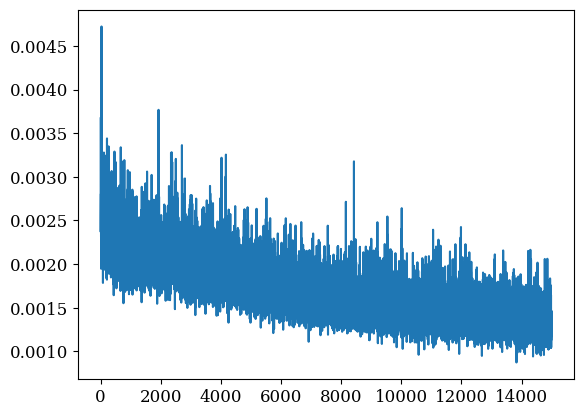

In [16]:
# View the loss curve
plt.plot(losses[-15000:])

# save losses
# np.save('models/history/'+model_name+'.npy', losses)

In [10]:
# save model
torch.save(net.state_dict(), 'models/'+model_name+'.pt')

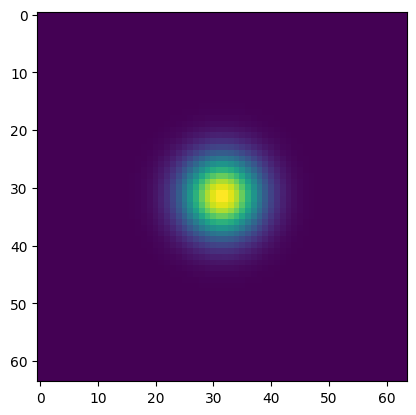

In [11]:
for x, ci, y in train_dataloader:
    y = torch.argmax(y, dim=1)
    im = x[0].reshape(1, 1, 64, 64).cpu()

    fig, ax = plt.subplots()
    ax.imshow(im.reshape(64, 64))
    break

Loading fits image:  /home/lai075/GitHub/CI_ImRec/Images/ellipse.fits


0it [00:00, ?it/s]

1000it [01:04, 15.49it/s]


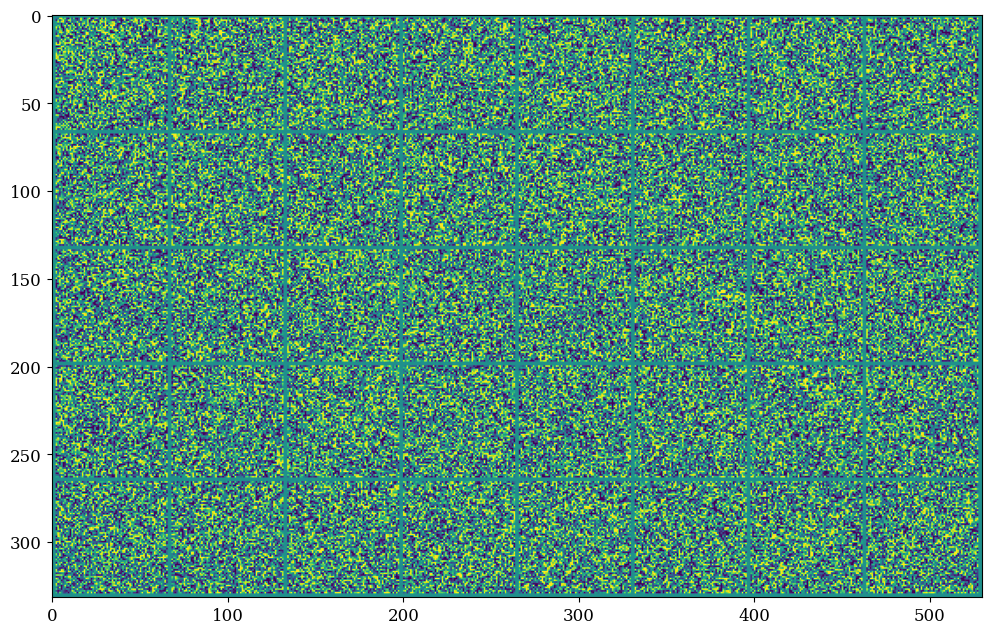

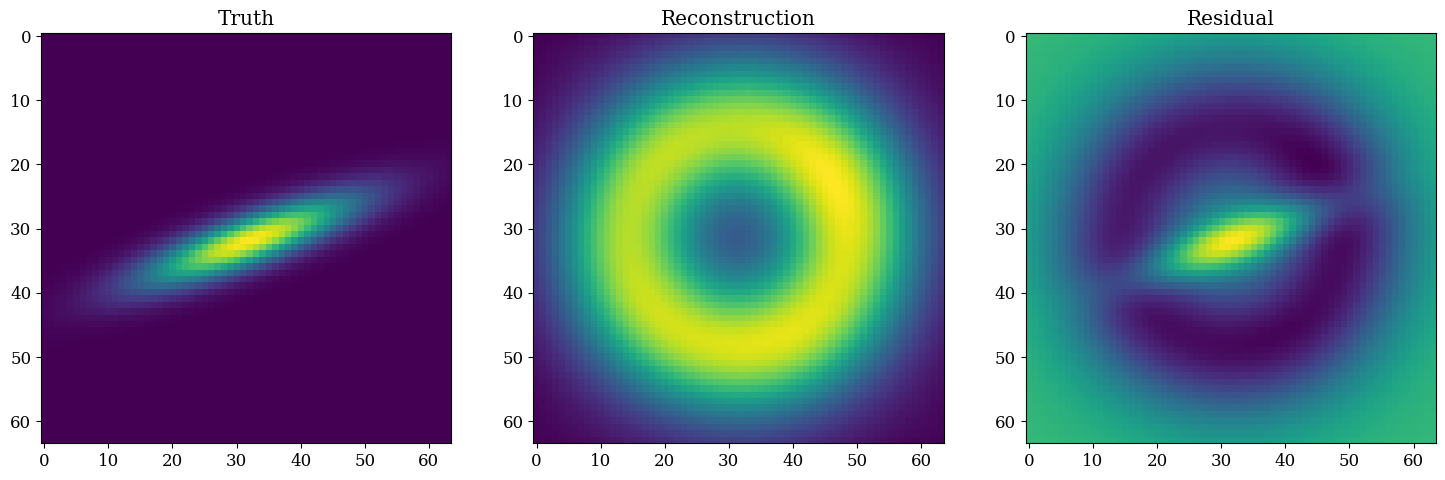

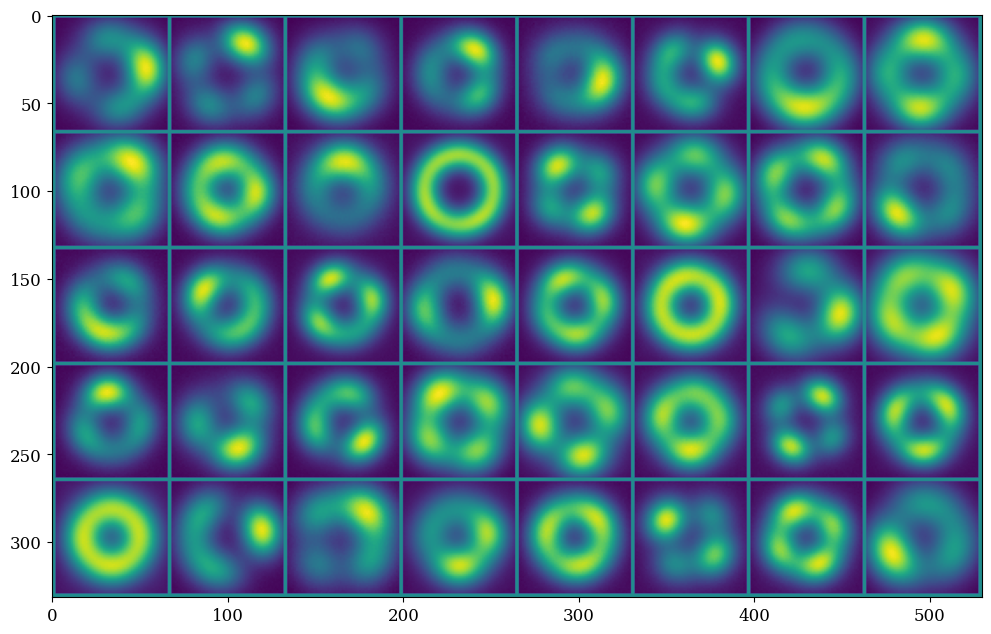

In [20]:
# test with custom image

import ehtim as eh

imgdim = 64

load_fits = '/home/lai075/GitHub/CI_ImRec/Images/ellipse.fits'

img = eh.image.load_fits(load_fits)

name = load_fits.split('/')[-1].split('.')[0]

im = img.regrid_image(img.fovx(), imgdim)
im = im.imarr()

im = im/np.max(im) # normalise the intensity
im = val_transforms(im)

Closure = CI.Closure_Invariants('data/ehtuv.npz')
invs = Closure.FTCI(np.array([im])).reshape(-1)

invs = torch.Tensor(invs).reshape(1, -1)
invs = invs.to(device)

im = np.array(im.reshape(imgdim, imgdim))

# load model from .pt
net = UNet2DCondition().to(device)
net.load_state_dict(torch.load('models/'+model_name+'.pt'))

# Sampling some different digits:
n_classes = len(mnames)
n_images = batch_size
# Prepare random x to start from, plus some desired labels y
x = torch.randn(int(n_classes*n_images), 1, 64, 64).to(device)
y = torch.tensor([[i] * n_images for i in range(n_classes)]).flatten().to(device)

fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ax.imshow(torchvision.utils.make_grid(x.detach().cpu().clip(-1, 1), nrow=n_images)[0])

invs = invs.repeat(int(n_classes*n_images), 1)
invs = invs.reshape(-1, 1, invs.shape[-1])

# Sampling loop
for i, t in tqdm(enumerate(noise_scheduler.timesteps)):

    # Get model pred
    with torch.no_grad():
        residual = net(x, t, invs, guidance_scale=1E3)

    # Update sample with step
    x = noise_scheduler.step(residual, t, x).prev_sample

x_mean = x.mean(dim=0).cpu().numpy().reshape(64, 64)
# Show the results
fig, ax = plt.subplots(1, 3, figsize=(18, 6))
ax[0].imshow(im)
ax[0].set_title('Truth')
ax[1].imshow(x_mean)
ax[1].set_title('Reconstruction')
ax[2].imshow(im - x_mean)
ax[2].set_title('Residual')


fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ax.imshow(torchvision.utils.make_grid(x.detach().cpu().clip(-1, 1), nrow=n_images)[0])